<a href="https://colab.research.google.com/github/yleng204/Lhy_Machine_Learning/blob/main/%E2%80%9CWikipedia_Comments_Chunking_Approach_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wikipedia Comments - Chunking Approach

By Chris McCormick



This Notebook is a modified version of the [Document Classification tutorial](https://colab.research.google.com/drive/1CfsGHuNWGGLg7ArPD_WE3sRuzFbDJav8). 

In this version, I've implemented "chunking" as a possible workaround to BERT's maximum input-length problem.

The following sections are unchanged, and you can skim / skip them:
* S1. Setup
* S2. Retrieve & Inspect Dataset
* S4. Train Our Classification Model

The key changes are in:
* S3. Tokenize with Chunking
* S5. Performance on Test Set



**Overall Approach**
1. In the training set, split apart any comment which is longer than `max_len` (I used `max_len = 128` here) into multiple chunks. 
    * The chunks all get the same label as the original comment.
    * There are 69,526 training samples before chunking, and 98,466 samples after chunking with `max_len = 128`.
2. Train BERT on all of the chunks as if they were all separate samples.
3. Apply the same chunking approach to the test set...
    * For the test samples, keep track of the original comment ID that each chunk came from. Use a Python Dictionary to map each original ID to the list of IDs of its chunks. 
4. To evaluate on the test set:
    1. Run all of the chunks through the model and record the "logits" (the output of the classifier prior to activation function) for all chunks.
    2. For each *original test sample* average together the logits for all of its chunks. 
    3. Use the averaged result to make the prediction! 


# Contents

See "Table of contents" in the sidebar to the left.

# Part I - Setup & Dataset Prep
-------------------------------

## S1. Setup


### 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. 

In [ ]:
!pip install transformers

     |████████████████████████████████| 675kB 7.9MB/s 
     |████████████████████████████████| 890kB 21.8MB/s 
     |████████████████████████████████| 1.1MB 40.8MB/s 
     |████████████████████████████████| 3.8MB 51.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=84fc923da46bb3023f0a43a482714c50d5d4913b73a497869f8ba78c8425b403
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## S2. Retrieve & Inspect Dataset




This notebook will download and tokenize a text dataset comprised of comments on Wikipedia which contain "attacks" on other users (plus counter-examples). 

We'll use `pandas` to parse the dataset `.tsv` file, and we'll use the gensim function `gensim.utils.simple_preprocess` for tokenizing the sentences.

We'll save the processed dataset back to disk for use in other notebooks.

**About the Dataset**

* wikimedia page describing the dataset [here](https://figshare.com/articles/Wikipedia_Talk_Labels_Personal_Attacks/4054689).
* Dataset download page on figshare.com for the personal attack comments [here](https://figshare.com/articles/Wikipedia_Talk_Labels_Personal_Attacks/4054689).
    * `attack_annotated_comments.tsv  -  ` contains the comment text and some properties.
    * `attack_annotations.tsv  -  ` contains the labels (whether the comment contains an attack).
* Example notebook (from the authors) for getting started with the dataset [here](https://github.com/ewulczyn/wiki-detox/blob/master/src/figshare/Wikipedia%20Talk%20Data%20-%20Getting%20Started.ipynb).

### 2.1. Download
--------------------------------------
Download the text.

In [ ]:
import urllib
import os

# Create the data subdirectory if not there.
if not os.path.exists('./data/'):
    os.mkdir('./data/')

files = [
    ('./data/attack_annotated_comments.tsv',  'https://ndownloader.figshare.com/files/7554634'),
    ('./data/attack_annotations.tsv',         'https://ndownloader.figshare.com/files/7554637')   
]    
    
for (filename, url) in files:
    # Download download if we already have it!
    if not os.path.exists(filename):

        # Download the dataset.
        print('Downloading', filename)
        
        urllib.request.urlretrieve(url, filename)

        print('  DONE.')



  DONE.
  DONE.


### 2.2. Parse & Inspect
-------------------
We'll use `pandas` just to help us parse the tab-separated `.tsv` file. 


In [ ]:
import pandas as pd

print('Parsing the dataset .tsv file...')
comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep = '\t')

print('    Done.')

Parsing the dataset .tsv file...
    Done.


Let's take a look at the first few rows of the table just to see what's in there.

In [ ]:
# Display the first five rows of the table.
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


The dataset is split into 'train', 'test', and 'dev'--how big are each of these?

In [ ]:
comments[['comment', 'split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [ ]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


Label the comments.

In [ ]:
# Label a comment as an atack if the majority of annoatators did so
# The comments are uniquely identified by their 'rev_id'. The annotations table
# has multiple rows for each comment because there were multiple labelers.
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

# Join labels and comments
comments['attack'] = labels

In [ ]:
# Remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

Divide the dataset into training and test comments.

In [ ]:
# fit a simple text classifier
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

Display some of the comments labeled as containing an attack. Be prepared to see some terrible human behavior... 

In [ ]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Filter to just the "attack" comments.
attack_examples = train_comments.query('attack')['comment']

# Randomly choose some examples.
for i in range(10):
    j = random.choice(attack_examples.index)
    
    print('')
    print(wrapper.fill(attack_examples[j]))
    print('')



 :::::: Nice to know you back nazi's


`:::# You're an idiot. Throwing a punch is a causal act. The causal actor in the
case of words is the recipient, not the speaker, and certainly not the words.
Again, you're an idiot. :::# The purpose is clear: to not have the noticeboard
connected with her/his account. :::# I'm under no obligation to kiss the asses
of market fundamentalists and beg them if I can edit ``their`` articles to
replace fantasy with reality. The fact that I'm the one being pigpiled here,
instead of them, is quite telling. :::# Telling bullies who visit my talk page
to fuck off is not disruptive to the project.  `


`  I reverted the armor section back to describing all the armors you can unlock
because I think it is an interesting topic to have and because this article
needs more information.    :Wikipedia is not a gameguide    Possibly the dumbest
argument I have ever heard. Are all wikipedia users fags or just you? The
Wikipedia is not a gameguide retardedness doesn't

What percentage of the comments are attacks?

In [ ]:
total_comments = len(comments)
num_attacks = len(comments.query('attack'))

print('{:,} of {:,} comments are attacks ({:.2%})'.format(num_attacks, total_comments, num_attacks/total_comments))

13,590 of 115,864 comments are attacks (11.73%)


The classes are very imbalanced, so we have to be careful interpreting our accuracy...

In [ ]:
prcnt_non_attack = 1 - (len(test_comments.query('attack')) / len(test_comments))

print('Always predicting "not attack" will yield {:.2%} accuracy on the test set.'.format(prcnt_non_attack))

Always predicting "not attack" will yield 88.11% accuracy on the test set.


## S3. Tokenize with Chunking

### 3.1. Load Tokenizer

First we'll need to load the BERT tokenizer.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


### 3.2. Tokenize with Chunking

For the training set, we can simply split the comments into chunks, and then treat each of these chunks as its own training sample.

Note: Running the tokenizer against longer-than-512 token sentences causes a warning to appear in the output cell, which we can ignore.Sorry for the cluttered output, though! 

In [ ]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

# Get the labels from the DataFrame, and convert from booleans to ints.
train_labels = train_comments.attack.to_numpy().astype(int)

# Labels after some of the comments are divided into chunks.
chunk_labels = []

print('Tokenizing comments...')

# For every sentence...
for i, sen in enumerate(train_comments.comment):
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Get the label for this sentence.
    label = train_labels[i]

    # If the sentence is too long, chunk it.
    if len(encoded_sent) > 128:

        # Strip off special tokens.
        encoded_sent = encoded_sent[1:-1]
        #print('Sentence length:', len(encoded_sent))

        # Chunk the sentence, each sentence needs its own CLS and SEP tokens.
        chunk_len = 128 - 2

        # Make chunks...

        # For each starting index...
        for j in range(0, len(encoded_sent), chunk_len):
        
            # Make sure the end index doesn't go beyond the list.
            #end = min(j+chunk_len, len(encoded_sent) + 1)

            # What's the actual chunk length?
            #actual_len = end - j

            # Select the tokens. Note: Python slicing syntax makes this easier--
            # for the last chunk, even if the end index is past the end of the
            # list, the slice will just return what's there.
            tokens = encoded_sent[j:j+chunk_len]

            # Add the special tokens.
            chunk = [tokenizer.cls_token_id] + tokens + [tokenizer.sep_token_id]

            #print('  ', len(chunk))

            # Add the chunk to our encoded sentences.
            input_ids.append(chunk)

            # Give all the chunks the same label.
            chunk_labels.append(label) 
    
    # Otherwise, just add it to the list.
    else:
        input_ids.append(encoded_sent)
        chunk_labels.append(label)

print('DONE.')
print('{:>10,} comments before chunking'.format(len(train_comments)))
print('{:>10,} comments after chunking'.format(len(input_ids)))

Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
  Read 0 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (1088 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (791 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

  Read 20,000 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (1012 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1154 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (873 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (888 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1229 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

  Read 60,000 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (1509 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (845 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (745 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2255 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

DONE.
    69,526 comments before chunking
    98,466 comments after chunking


In [ ]:
# The number of samples and number of labels should match.
assert(len(input_ids) == len(chunk_labels))

Check out the class distribution for this dataset.

In [ ]:
print('{:>7,} positive (contains attack)'.format(np.sum(chunk_labels)))
print('{:>7,} negative (not an attack)'.format(len(chunk_labels) - np.sum(chunk_labels)))

 11,709 positive (contains attack)
 86,757 negative (not an attack)


### 3.3. Pad Comments

Some of the samples will still need to be padded out to 128 tokens (because they were less than 128 to begin with, or because they are the tail-end chunk of a sample), so let's do that here.

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the required sequence length.
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

Using TensorFlow backend.



Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


**Attention Masks**

The attention mask simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

### 3.4. Final Data Prep


We a few small data preparation steps to complete before we can move on to training and test.

(1) Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, chunk_labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, chunk_labels,
                                             random_state=2018, test_size=0.1)

(2) Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

(3) We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Part II - BERT Fine-Tuning

## S4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

### 4.1. BertForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

### 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 4.3. Training Loop

In each pass, we will train the model on our full training set, and then measure it's accuracy on our 10% holdout validation set.

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  2,770.    Elapsed: 0:00:38.
  Batch   200  of  2,770.    Elapsed: 0:01:15.
  Batch   300  of  2,770.    Elapsed: 0:01:53.
  Batch   400  of  2,770.    Elapsed: 0:02:30.
  Batch   500  of  2,770.    Elapsed: 0:03:08.
  Batch   600  of  2,770.    Elapsed: 0:03:45.
  Batch   700  of  2,770.    Elapsed: 0:04:23.
  Batch   800  of  2,770.    Elapsed: 0:05:00.
  Batch   900  of  2,770.    Elapsed: 0:05:38.
  Batch 1,000  of  2,770.    Elapsed: 0:06:15.
  Batch 1,100  of  2,770.    Elapsed: 0:06:52.
  Batch 1,200  of  2,770.    Elapsed: 0:07:30.
  Batch 1,300  of  2,770.    Elapsed: 0:08:07.
  Batch 1,400  of  2,770.    Elapsed: 0:08:45.
  Batch 1,500  of  2,770.    Elapsed: 0:09:22.
  Batch 1,600  of  2,770.    Elapsed: 0:10:00.
  Batch 1,700  of  2,770.    Elapsed: 0:10:37.
  Batch 1,800  of  2,770.    Elapsed: 0:11:15.
  Batch 1,900  of  2,770.    Elapsed: 0:11:52.
  Batch 2,000  of  2,770.    Elapsed: 0:12:29.
  Batch 2,100  of

Let's take a look at our training loss over all batches:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


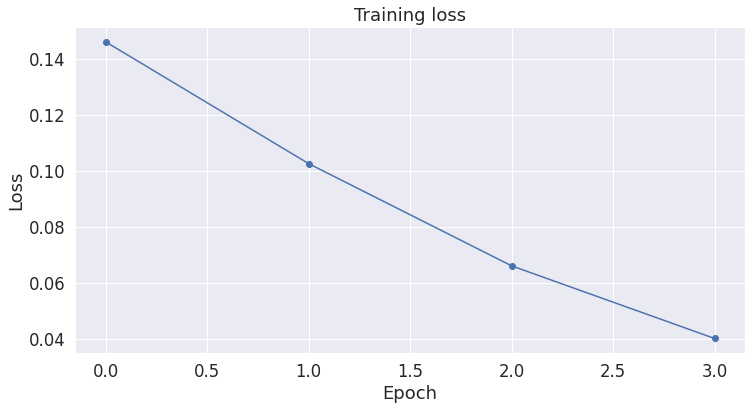

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## S5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set.

### 5.1. Tokenize Test Set with Chunking



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

**Chunk the Test Samples**

In [ ]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test_comments.attack.to_numpy().astype(int)

# Labels after some of the comments are divided into chunks.
chunk_labels = []

print('Tokenizing comments...')

# Build a Python Dictionary which maps each original test sample to its list of
# chunks.
orig_to_chunk = {}

# For every sentence...
for i, sen in enumerate(test_comments.comment):
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    

    # Create the list of chunk indeces for this test sample.
    orig_to_chunk[i] = []

    # If the sentence is too long, chunk it.
    if len(encoded_sent) > 128:

        # Strip off special tokens.
        encoded_sent = encoded_sent[1:-1]
        #print('Sentence length:', len(encoded_sent))

        # Specify the length of our chunks. Each sentence needs its own CLS and 
        # SEP tokens, so to get sequences of 128 tokens, we need to
        # create chunks of at most 126 tokens.
        chunk_len = 128 - 2

        # Make chunks...

        # For each starting index...
        for j in range(0, len(encoded_sent), chunk_len):
        
            # Make sure the end index doesn't go beyond the list.
            #end = min(j+chunk_len, len(encoded_sent) + 1)

            # What's the actual chunk length?
            #actual_len = end - j

            # Select the tokens. Note: Python slicing syntax makes this easier--
            # for the last chunk, even if the end index is past the end of the
            # list, the slice will just return what's there.
            tokens = encoded_sent[j:j+chunk_len]

            # Add the special tokens.
            chunk = [tokenizer.cls_token_id] + tokens + [tokenizer.sep_token_id]

            #print('  ', len(chunk))

            # Add the chunk to our encoded sentences.
            input_ids.append(chunk)

            # Map from the original test sample index to the index of this 
            # chunk.
            orig_to_chunk[i].append(len(input_ids) - 1)
    
    # Otherwise, just add it to the list.
    else:
        input_ids.append(encoded_sent)
        chunk_labels.append(label)

        # Map from the original test sample index to the index of its only
        # chunk.        
        orig_to_chunk[i].append(len(input_ids) - 1)

print('DONE.')
print('{:>10,} comments before chunking'.format(len(test_comments)))
print('{:>10,} comments after chunking'.format(len(input_ids)))

Token indices sequence length is longer than the specified maximum sequence length for this model (1033 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
  Read 0 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (943 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (949 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

DONE.
    23,178 comments before chunking
    33,021 comments after chunking


Add padding and attention masks, and create the data loader.

In [ ]:
# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test_comments.attack.to_numpy().astype(int)

print('{:>10,} positive (contains attack)'.format(np.sum(test_labels)))
print('{:>10,} negative (not an attack)'.format(len(test_labels) - np.sum(test_labels)))

# For evaluating the test set, the individual chunk labels don't matter, so
# we'll just make the list all zeros.
chunk_labels = [0]*len(input_ids)

# Pad our input tokens
test_input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
chunk_labels = torch.tensor(chunk_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, chunk_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

     2,756 positive (contains attack)
    20,422 negative (not an attack)


### 5.2. Evaluate on Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

There are no changes required in this cell for chunking--we'll just run all of the chunks through the model and retrieve the logits. Then, in the next section, we'll average together the appropriate outputs.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits to CPU
    logits = logits.detach().cpu().numpy()
  
    # Store predictions and true labels
    predictions.append(logits)

print('    DONE.')

Predicting labels for 33,021 test sentences...
  Batch   100  of  1,032.    Elapsed: 0:00:12.
  Batch   200  of  1,032.    Elapsed: 0:00:23.
  Batch   300  of  1,032.    Elapsed: 0:00:35.
  Batch   400  of  1,032.    Elapsed: 0:00:47.
  Batch   500  of  1,032.    Elapsed: 0:00:58.
  Batch   600  of  1,032.    Elapsed: 0:01:10.
  Batch   700  of  1,032.    Elapsed: 0:01:22.
  Batch   800  of  1,032.    Elapsed: 0:01:33.
  Batch   900  of  1,032.    Elapsed: 0:01:45.
  Batch 1,000  of  1,032.    Elapsed: 0:01:57.
    DONE.


In [ ]:
len(predictions)

1032

`predictions` has one element per batch. Collapse the batches so we have one continuous list of predictions.

In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)

Here are the outputs for the first 5 samples / chunks. There are two columns--the first column is the output of the "label 0" (not an attack) classifier head, and the other is the output of the "label 1" (contains an attack) classifier.

In [ ]:
predictions[0:5]

array([[ 4.4640837, -4.6595287],
       [ 4.686941 , -4.946677 ],
       [ 4.82496  , -4.9707165],
       [ 4.7757807, -4.7863073],
       [ 4.7885265, -4.7588243]], dtype=float32)

#### Using Only the First Chunk (Sanity Check)

As a kind of sanity test, we can use just the predictions on the first chunk of every sample. We'd expect this to achieve close to the same accuracy that we got in the original Notebook, since this is equivalent to just truncating the test samples.

The only difference is that in this notebook we had more training samples, because we trained on all of the chunks. 

In [ ]:
# Get the labels for the original (unchunked) comments.
true_labels = test_comments.attack.to_numpy().astype(int)

p1 = []

# For each of the original test samples...
for test_i in range(0, len(true_labels)):

    # `chunk_i` is the index into `predictions` for the first chunk of test 
    # sample `test_i`.
    chunk_i = orig_to_chunk[test_i][0]

    # `predictions` has two columns--take the output from the "label 1" 
    # classifier to use for our prediction.
    p1.append(predictions[chunk_i, 1])

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.964


This is *lower* than the score we got in the original notebook! There we got `0.969`. 

The only difference (besides the possibility of some randomness...) is that this model was trained on additional samples--the remaining chunks. This suggests to me that these additional chunks may have actually confused the model more than helped it.

Let's see how our performance on the test set goes when we average together the scores for the chunks.

#### Averaging Together Chunk Scores

Here, for a given *original* (full-text) test sample, we'll select the outputs for all of its chunks, and average them together for our prediction.

In [ ]:
# Get the labels for the original (unchunked) comments.
true_labels = test_comments.attack.to_numpy().astype(int)

p1 = []

# For each of the original test samples...
for test_i in range(0, len(true_labels)):

    # `chunk_indeces` is the list of indeces in `predictions` of the chunks for
    # sample `test_i`.
    chunk_indeces = orig_to_chunk[test_i]

    # Select the outputs of the "label 1" classifier for all chunks
    chunks_outputs = predictions[chunk_indeces, 1]

    # Average them and use this as the prediction.
    p1.append(np.mean(chunks_outputs))

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.969


Here are the key scores for comparison:
* Baseline performance using tf-idf + Logistic Regression: `0.957`
* BERT with truncating to 128 tokens: `0.969`
* BERT with chunking to 128 tokens: `0.969`

Unfortunately, it looks like chunking hasn't improved our score!

That said, it may still be worth applying this technique to your own application, especially if you suspect that truncating the text is hurting your performance.



**Additional Modifications to Try**
* Perhaps some of the tail-end chunks (the last chunk created from a comment) end up too short, and shouldn't be used?
    * When creating the training and test sets, you could try filtering out any tail-end chunks which are less than, e.g., 32 tokens. 
    * For the test set, you could also try weighting the chunk scores by sequence length, so that the shorter the final chunk is, the less influence it has on the average. 


## S6. Save Trained Model


### 6.1. Saving to Disk

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

### 6.2. Backing Up to Google Drive

To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gdrive_path = "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

In [ ]:
!ls -l "./drive/My Drive/BERT Document Classification Tutorial/model_save/"